# Instructions :
Travail en groupe, à  placer dans le premier dépot Git de notre année Universitaire, dans le dossier <code>Computer Vision</code>.


# Membres du Groupe :

1. RAJOHNSON Fitia n°02
2. LAZAHARIVELO Jakina Andriantsoa n°11
3. ANDRIANIRINA Tsanta Fitiavana n°38
4. RAMANDIMBISON Ezra Niel n°44
5. ANDRITIANA FANORENANTSOA Steddi Karen n°51
6. RANDRIANAVALONA Mahefa Nirina n°55


# Autoencodeurs pour Images de Cercles

Dans ce notebook, nous allons générer un dataset synthétique où chaque image est une image en niveaux de gris de taille 64x64 contenant un cercle blanc (de centre et rayon aléatoires) sur fond noir. Le but est d'entraîner des autoencodeurs qui réduisent ces images dans un espace latent de dimension 3, puis les reconstruisent.

Nous étudierons deux configurations :
- Un autoencodeur entièrement connecté
- Un autoencodeur convolutionnel

Vous pourrez comparer leurs performances et discuter des compromis liés à la conception de l'espace latent.

## Étape 1 : Génération du Dataset

Nous allons générer un dataset d'images où chaque image comporte un cercle blanc de centre et de rayon aléatoires. Pour cela, nous utiliserons la bibliothèque OpenCV pour dessiner le cercle sur une image noire.

### Explication Pratique
La génération d'un dataset synthétique permet de contrôler précisément les paramètres (ici, le centre et le rayon du cercle) et de disposer d'une base simple pour expérimenter la réduction dimensionnelle via l'espace latent.

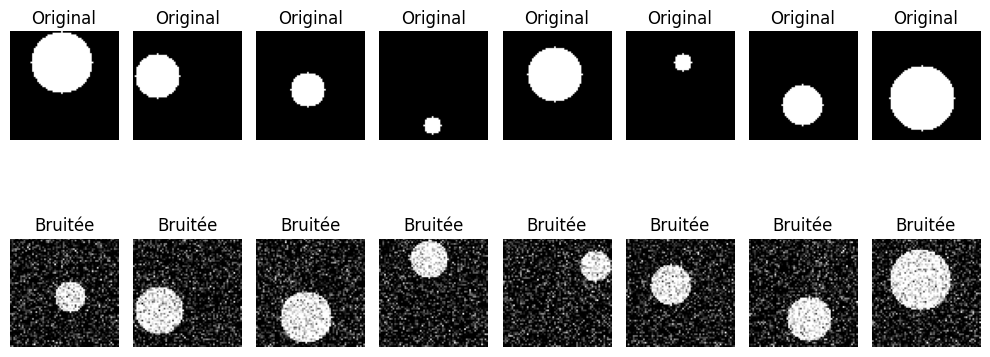

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def generate_circle_image(image_size=64, min_radius=5, max_radius=20):
    """Génère une image en niveaux de gris de taille image_size x image_size contenant un cercle blanc."""
    # Créer une image noire
    image = np.zeros((image_size, image_size), dtype=np.uint8)

    # Choisir un rayon aléatoire
    radius = np.random.randint(min_radius, max_radius)

    # Choisir un centre aléatoire de sorte que le cercle soit entièrement contenu dans l'image
    x = np.random.randint(radius, image_size - radius)
    y = np.random.randint(radius, image_size - radius)

    # Dessiner le cercle (couleur blanche: 255, épaisseur=-1 pour un remplissage complet)
    cv2.circle(image, (x, y), radius, 255, -1)

    # Normaliser l'image entre 0 et 1
    image = image.astype('float32') / 255.0

    return image

def add_noise(image, noise_level=0.1):
    """Ajoute du bruit à l'image."""
    # Générer du bruit
    noise = np.random.normal(loc=0.0, scale=noise_level, size=image.shape)
    # Ajouter le bruit à l'image
    noisy_image = image + noise
    # Clip les valeurs entre 0 et 1
    noisy_image = np.clip(noisy_image, 0.0, 1.0)

    return noisy_image

def generate_dataset(n_samples=10000, image_size=64, add_noise_flag=False, noise_level=0.1):
    data = []
    for _ in range(n_samples):
        img = generate_circle_image(image_size=image_size)
        if add_noise_flag:
            img = add_noise(img, noise_level=noise_level)
        data.append(img)
    data = np.array(data)
    # Ajouter une dimension pour le canal (images en niveaux de gris)
    data = np.expand_dims(data, axis=-1)
    return data

# Générer le dataset avec et sans bruit
data_clean = generate_dataset(n_samples=10000, image_size=64)
data_noisy = generate_dataset(n_samples=10000, image_size=64, add_noise_flag=True, noise_level=0.3)

# Afficher quelques exemples comparatifs
plt.figure(figsize=(10, 5))
for i in range(8):
    # Image originale
    plt.subplot(2, 8, i+1)
    plt.imshow(data_clean[i].squeeze(), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Image bruitée
    plt.subplot(2, 8, i+9)
    plt.imshow(data_noisy[i].squeeze(), cmap='gray')
    plt.title('Bruitée')
    plt.axis('off')
plt.tight_layout()
plt.show()





Voici les explications des modifications apportées au code et leur pertinence pour l'expérimentation demandée :

1. Ajout du bruit (add_noise)
- But expérimental : Simuler des imperfections réalistes dans les images d'entrée
- Mécanisme :
  - Génération d'un bruit aléatoire

2. Modification de generate_dataset
- Nouveaux paramètres :
  - `add_noise_flag` : Active/désactive le bruit
  - `noise_level` : Contrôle l'intensité du bruit

3. Visualisation comparative
- Affichage côte à côte : Met en évidence l'effet du bruit sur 8 paires d'images
- Titres explicites : Aide à distinguer visuellement les versions originales et modifiées
- Paramètre noise_level=0.3 : Choix d'un bruit visible mais pas écrasant pour l'expérimentation

Lien avec l'objectif expérimental
1. Test de robustesse :
- Les images bruitées testent la capacité des modèles à gérer des entrées dégradées
- Le bruit simule des imperfections d'acquisition courantes

2. Interprétation des résultats :
- Modèle non robuste : Baisse significative de performance sur data_noisy
- Modèle robuste : Résultats similaires sur data_clean et data_noisy

## Étape 2 : Préparation des Données

Nous allons diviser le dataset en ensembles d'entraînement et de test. Ici, nous utilisons 80 % des données pour l'entraînement et 20 % pour le test.

In [26]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data_clean, test_size=0.2, random_state=42)

print('Entraînement:', train_data.shape)
print('Test:', test_data.shape)


Entraînement: (8000, 64, 64, 1)
Test: (2000, 64, 64, 1)


## Étape 3 : Autoencodeur Entièrement Connecté (Dense Layers)

Dans cette partie, nous construisons un autoencodeur entièrement connecté. Le modèle comporte :

- **Encodeur :** Un aplatissement de l'image suivi d'une couche Dense de 128 neurones (activation ReLU) puis une couche Dense de 3 neurones qui représente l'espace latent.
- **Décodeur :** Une couche Dense de 128 neurones (activation ReLU), suivie d'une couche Dense de 4096 neurones (pour reconstruire une image 64x64) avec activation sigmoïde, puis un reshape en (64,64,1).

### Explication Pratique
Cet autoencodeur simple permet de voir comment les informations (ici, la position et la taille du cercle) sont comprimées dans un espace de très faible dimension.

In [54]:
from tensorflow.keras import layers, models, regularizers

def improved_conv_autoencoder():
    # Encoder
    input_img = layers.Input(shape=(64, 64, 1))

    # Bloc convolutif avec connexion résiduelle
    x = layers.Conv2D(32, (3,3), padding='same')(input_img)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)

    residual = x
    x = layers.Conv2D(32, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, residual])
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.MaxPooling2D((2,2), padding='same')(x)

    # Deuxième bloc avec régularisation
    x = layers.Conv2D(64, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.MaxPooling2D((2,2), padding='same')(x)

    # Troisième bloc avec régularisation
    x = layers.Conv2D(64, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.MaxPooling2D((2,2), padding='same')(x)

    # Espace latent inchangé
    x = layers.Flatten()(x)
    latent = layers.Dense(3, name='latent_space')(x)

    # Decoder amélioré
    x = layers.Dense(16*16*128, activation='relu')(latent)
    x = layers.Reshape((16,16,128))(x)

    # Bloc de déconvolution avec skip connections
    x = layers.Conv2DTranspose(128, (3,3), strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2DTranspose(64, (3,3), strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)

    # Couche finale avec régularisation
    decoded = layers.Conv2D(1, (3,3), activation='sigmoid', padding='same',
                          kernel_regularizer=regularizers.l2(1e-4))(x)

    return models.Model(input_img, decoded)

# Compilation avec paramètres optimisés
autoencoder = improved_conv_autoencoder()
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()





Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15            │ (None, 64, 64, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_54 (Conv2D)        │ (None, 64, 64, 32)     │            320 │ input_layer_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_50    │ (None, 64, 64, 32)     │            128 │ conv2d_54[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_42            │ (None, 64, 64, 32)     │              0 │ batch_normalization_5… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_55 (Conv2D)        │ (None, 64, 64, 32)     │          9,248 │ leaky_re_lu_42[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_51    │ (None, 64, 64, 32)     │            128 │ conv2d_55[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_7 (Add)               │ (None, 64, 64, 32)     │              0 │ batch_normalization_5… │
│                           │                        │                │ leaky_re_lu_42[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_43            │ (None, 64, 64, 32)     │              0 │ add_7[0][0]            │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_32          │ (None, 32, 32, 32)     │              0 │ leaky_re_lu_43[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_56 (Conv2D)        │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d_32[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_52    │ (None, 32, 32, 64)     │            256 │ conv2d_56[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_44            │ (None, 32, 32, 64)     │              0 │ batch_normalization_5… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_24 (Dropout)      │ (None, 32, 32, 64)     │              0 │ leaky_re_lu_44[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_33          │ (None, 16, 16, 64)     │              0 │ dropout_24[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_57 (Conv2D)   

 Total params: 431,844 (1.65 MB)

 Trainable params: 431,076 (1.64 MB)

 Non-trainable params: 768 (3.00 KB)

# Changements apportés:

1. Extraction de caractéristiques hiérarchiques :

  x = layers.Conv2D(64, (3,3), padding='same')(x)
  Augmente le nombre de filtres (32 → 64) pour capturer des motifs plus complexes
  Kernel 3x3 : détecte des motifs locaux (bords, courbes, textures)
  Padding 'same' : préserve la résolution spatiale

2. Stabilisation de l'apprentissage :

  x = layers.BatchNormalization()(x)
  Normalise les sorties de la couche précédente

  Réduit les problèmes de covariance interne (internal covariate shift)
  Permet d'utiliser des taux d'apprentissage plus élevés

### Entraînement de l'Autoencodeur Entièrement Connecté FCN (Dense layers)

Nous allons entraîner cet autoencodeur sur l'ensemble d'entraînement.

In [52]:
history_fc = autoencoder_fc.fit(train_data, train_data,
                                  epochs=20,
                                  batch_size=128,
                                  shuffle=True,
                                  validation_data=(test_data, test_data))


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0085 - val_loss: 0.0150
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0084 - val_loss: 0.0149
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0084 - val_loss: 0.0148
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0083 - val_loss: 0.0149
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0082 - val_loss: 0.0148
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0083 - val_loss: 0.0152
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0083 - val_loss: 0.0150
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0083 - val_loss: 0.0149
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0084 - val_loss: 0.0151
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0087 - val_loss: 0.0159
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0089 - val_loss: 0.0153
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0084 - val_lo

### Visualisation des Reconstructions (FC)

Affichons quelques reconstructions pour évaluer qualitativement les performances de l'autoencodeur entièrement connecté.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


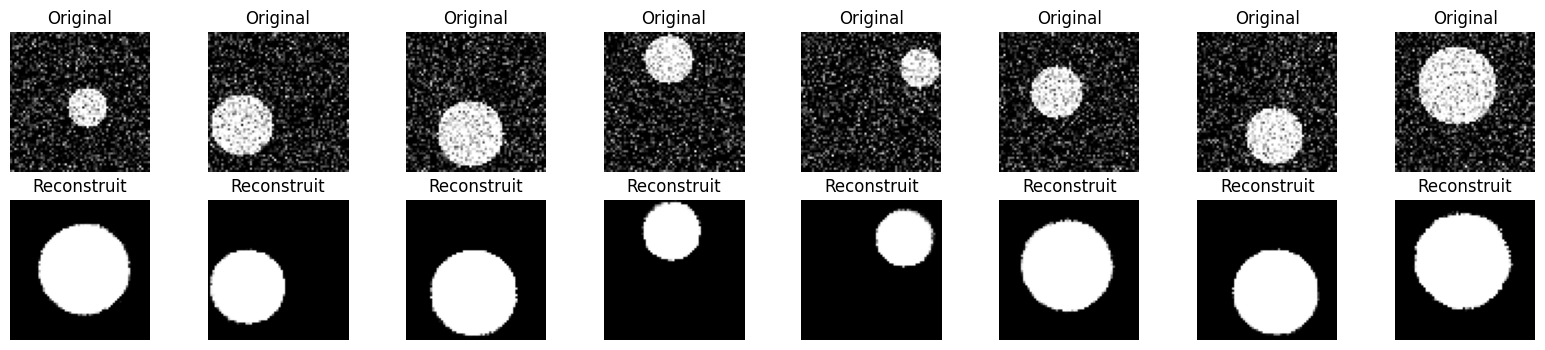

In [53]:
decoded_imgs_fc = autoencoder_fc.predict(data_noisy)

n = 8
plt.figure(figsize=(20, 4))
for i in range(n):
    # Afficher l'image originale
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(data_noisy[i].squeeze(), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Afficher l'image reconstruite
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_fc[i].squeeze(), cmap='gray')
    plt.title('Reconstruit')
    plt.axis('off')
plt.show()


## Étape 4 : Autoencodeur Convolutionnel

Nous allons maintenant construire un autoencodeur convolutionnel. Cette architecture est généralement mieux adaptée pour traiter des images car elle exploite la structure spatiale.

### Architecture
- **Encodeur :**
  - Conv2D(32, 3, activation='relu', padding='same')
  - MaxPooling2D((2,2), padding='same')
  - Conv2D(64, 3, activation='relu', padding='same')
  - MaxPooling2D((2,2), padding='same')
  - Flatten puis Dense(3) pour obtenir le latent space
- **Décodeur :**
  - Dense(16*16*64, activation='relu') puis Reshape en (16,16,64)
  - Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')
  - Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same')
  - Conv2D(1, 3, activation='sigmoid', padding='same') pour reconstruire l'image

### Explication Pratique
Les autoencodeurs convolutionnels capturent mieux la structure locale des images, ce qui peut améliorer la qualité des reconstructions par rapport à une architecture entièrement connectée.

In [30]:
input_img = layers.Input(shape=(64, 64, 1))

# Encodeur
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Flatten()(x)
latent = layers.Dense(3, name='latent_space')(x)

# Décodeur
x = layers.Dense(16*16*64, activation='relu')(latent)
x = layers.Reshape((16,16,64))(x)
x = layers.Conv2DTranspose(64, (3,3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(32, (3,3), strides=2, activation='relu', padding='same')(x)
decoded = layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

autoencoder_conv = models.Model(input_img, decoded)

autoencoder_conv.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_conv.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 64, 64, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_space (Dense)                 │ (None, 3)                   │          49,155 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 16384)               │          65,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_7 (Reshape)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_10                  │ (None, 32, 32, 64)          │          36,928 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_11                  │ (None, 64, 64, 32)          │          18,464 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 64, 64, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 189,188 (739.02 KB)

 Trainable params: 189,188 (739.02 KB)

 Non-trainable params: 0 (0.00 B)

### Entraînement de l'Autoencodeur Convolutionnel

Entraînons cet autoencodeur sur le même ensemble d'entraînement.

In [31]:
history_conv = autoencoder_conv.fit(train_data, train_data,
                                  epochs=20,
                                  batch_size=128,
                                  shuffle=True,
                                  validation_data=(test_data, test_data))


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 0.5273 - val_loss: 0.3141
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.3042 - val_loss: 0.2310
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.1806 - val_loss: 0.1060
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0963 - val_loss: 0.0744
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0655 - val_loss: 0.0488
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0450 - val_loss: 0.0370
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0343 - val_loss: 0.0320
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0303 - val_loss: 0.0331
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0277 - val_loss: 0.0249
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0236 - val_loss: 0.0221
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0211 - val_loss: 0.0286
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0

### Visualisation des Reconstructions (Convolutionnel)

Affichons quelques reconstructions pour comparer qualitativement les deux architectures.

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


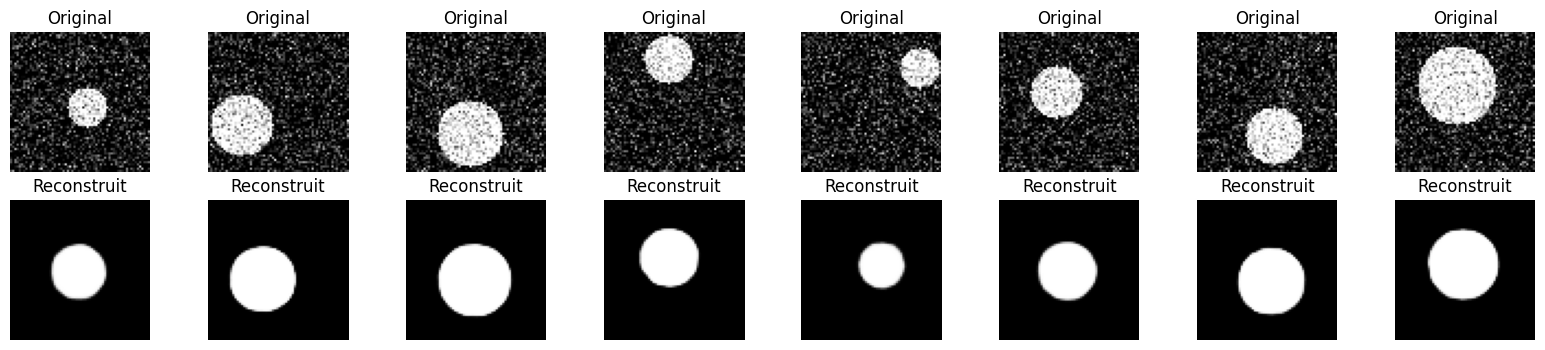

In [32]:
decoded_imgs_conv = autoencoder_conv.predict(data_noisy)

n = 8
plt.figure(figsize=(20, 4))
for i in range(n):
    # Afficher l'image originale
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(data_noisy[i].squeeze(), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Afficher l'image reconstruite
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_conv[i].squeeze(), cmap='gray')
    plt.title('Reconstruit')
    plt.axis('off')
plt.show()


Question 3:

-il n'est pas nécessaire d'augmenter la taille de l'espace latent pour avoir un réseau à faire ce travail car d'apres notre experience plus la valeur de l'espace latence augmente plus les images générés deviennent imparfaits.

## Expérimentations

1. Tester les deux modèles sur des images d'entrées imparfaites (avec les imperfections de votre choix : parties cachées, bruits, ...). Interpréter les résultats.
2. Améliorer un des modèles ci-dessus de votre choix et montrer le résultat (sans modifier la taille de l'espace latent).
3. Selon les expériences menées dans ce notebook, votre avis et vos conaissances, est-il nécessaire d'augmenter la taille de l'espace latent pour avoir un réseau à faire ce travail. **Argumenter** votre réponse.